In [2]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import ResNet50_Weights
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import functional as F
import torch
from tqdm import tqdm

COCO_LBL_NAMES = {
    0: "unlabeled",
    1: "person",
    2: "bicycle",
    3: "car",
    4: "motorcycle",
    5: "airplane",
    6: "bus",
    7: "train",
    8: "truck",
    9: "boat",
    10: "traffic",
    11: "fire",
    12: "street",
    13: "stop",
    14: "parking",
    15: "bench",
    16: "bird",
    17: "cat",
    18: "dog",
    19: "horse",
    20: "sheep",
    21: "cow",
    22: "elephant",
    23: "bear",
    24: "zebra",
    25: "giraffe",
    26: "hat",
    27: "backpack",
    28: "umbrella",
    29: "shoe",
    30: "eye",
    31: "handbag",
    32: "tie",
    33: "suitcase",
    34: "frisbee",
    35: "skis",
    36: "snowboard",
    37: "sports",
    38: "kite",
    39: "baseball",
    40: "baseball",
    41: "skateboard",
    42: "surfboard",
    43: "tennis",
    44: "bottle",
    45: "plate",
    46: "wine",
    47: "cup",
    48: "fork",
    49: "knife",
    50: "spoon",
    51: "bowl",
    52: "banana",
    53: "apple",
    54: "sandwich",
    55: "orange",
    56: "broccoli",
    57: "carrot",
    58: "hot",
    59: "pizza",
    60: "donut",
    61: "cake",
    62: "chair",
    63: "couch",
    64: "potted",
    65: "bed",
    66: "mirror",
    67: "dining",
    68: "window",
    69: "desk",
    70: "toilet",
    71: "door",
    72: "tv",
    73: "laptop",
    74: "mouse",
    75: "remote",
    76: "keyboard",
    77: "cell",
    78: "microwave",
    79: "oven",
    80: "toaster",
    81: "sink",
    82: "refrigerator",
    83: "blender",
    84: "book",
    85: "clock",
    86: "vase",
    87: "scissors",
    88: "teddy",
    89: "hair",
    90: "toothbrush",
    91: "hair",
    92: "banner",
    93: "blanket",
    94: "branch",
    95: "bridge",
    96: "building",
    97: "bush",
    98: "cabinet",
    99: "cage",
    100: "cardboard",
    101: "carpet",
    102: "ceiling",
    103: "ceiling",
    104: "cloth",
    105: "clothes",
    106: "clouds",
    107: "counter",
    108: "cupboard",
    109: "curtain",
    110: "desk",
    111: "dirt",
    112: "door",
    113: "fence",
    114: "floor",
    115: "floor",
    116: "floor",
    117: "floor",
    118: "floor",
    119: "flower",
    120: "fog",
    121: "food",
    122: "fruit",
    123: "furniture",
    124: "grass",
    125: "gravel",
    126: "ground",
    127: "hill",
    128: "house",
    129: "leaves",
    130: "light",
    131: "mat",
    132: "metal",
    133: "mirror",
    134: "moss",
    135: "mountain",
    136: "mud",
    137: "napkin",
    138: "net",
    139: "paper",
    140: "pavement",
    141: "pillow",
    142: "plant",
    143: "plastic",
    144: "platform",
    145: "playingfield",
    146: "railing",
    147: "railroad",
    148: "river",
    149: "road",
    150: "rock",
    151: "roof",
    152: "rug",
    153: "salad",
    154: "sand",
    155: "sea",
    156: "shelf",
    157: "sky",
    158: "skyscraper",
    159: "snow",
    160: "solid",
    161: "stairs",
    162: "stone",
    163: "straw",
    164: "structural",
    165: "table",
    166: "tent",
    167: "textile",
    168: "towel",
    169: "tree",
    170: "vegetable",
    171: "wall",
    172: "wall",
    173: "wall",
    174: "wall",
    175: "wall",
    176: "wall",
    177: "wall",
    178: "water",
    179: "waterdrops",
    180: "window",
    181: "window",
    182: "wood"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# TODO se io genero un adv img con la backbone e una head di classificazione poi magari uso la head per metric o obj detection dove le head cambiano verificare quanto l adv folla cioè quanto è basata a fregare la backbone piuttosto che gli ultimi layer
# TODO Inoltre puoi verificare come l adv (creata dalla net pretrained) si comporta su una net finetunnata per task simili 

# Dataset

## PAN

In [11]:
ATTACK_TYPE = "clean"
# DATA_ROOT = f'/mnt/ssd1t/datasets/PADetBench/generated_datasets_PADetBench/car/vehicle_{ATTACK_TYPE}_entire/val2017'
DATA_ROOT = '/mnt/ssd1t/datasets/AdvT-shirt/1_person'
LABEL = "person"
IDX_LABEL = 1 #3
#transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
transform = FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms()

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label, transform=None):
        self.img_dir = img_dir
        self.img_names = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.label

In [13]:
dataset = CustomImageDataset(DATA_ROOT, LABEL, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
len(dataloader)

220

In [15]:
dataset.img_names[:10]  # Show first 10 image names

['0213.jpg',
 '0178.jpg',
 '0052.jpg',
 '0194.jpg',
 '0112.jpg',
 '0053.jpg',
 '0179.jpg',
 '0047.jpg',
 '0139.jpg',
 '0016.jpg']

In [14]:
idx_sample = 2
sample = dataset[idx_sample][0]

# Revert normalization for visualization
#mean = np.array(transform.mean)
#std = np.array(transform.std)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = sample.permute(1, 2, 0).cpu().numpy()
img = (img * std) + mean
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.title(dataset[idx_sample][1])
plt.axis('off')
plt.show()

UnidentifiedImageError: cannot identify image file '/mnt/ssd1t/datasets/AdvT-shirt/1_person/0052.jpg'

## PADetBench

# Inference

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device)
model = model.eval()

## Show Bounding Box 

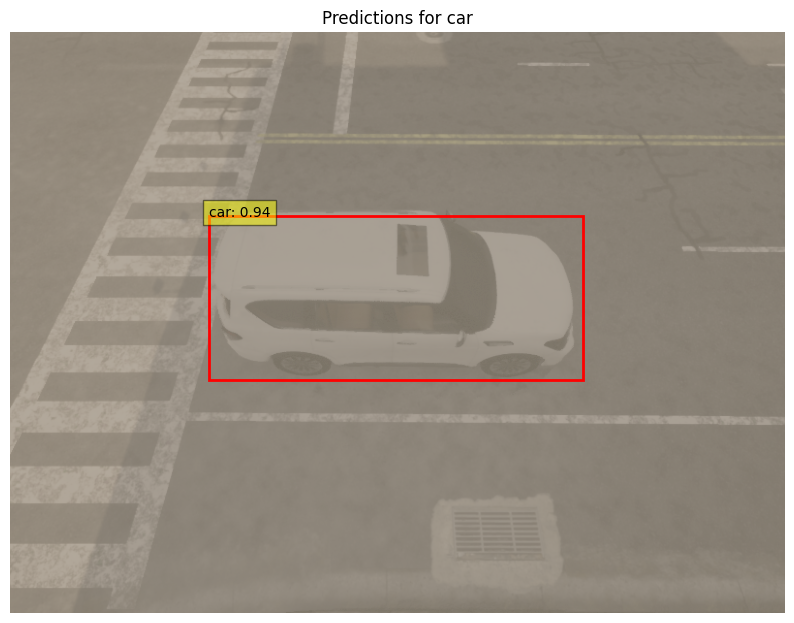

In [21]:
# Perform inference on a single image
idx_sample = 1
image, label = dataset[idx_sample]
#image = transform(Image.open('/content/generated_datasets_PADetBench/person/walker_mtd_weather/val2017/000023.png').convert('RGB'))
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    prediction = model(image)

# Plot the image and bounding boxes
img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = (img * std) + mean
img = np.clip(img, 0, 1)

plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
    # Filter by score threshold (e.g., 0.5)
    if score > 0.5:
        x1, y1, x2, y2 = box.tolist()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        label_name = COCO_LBL_NAMES[label.item()]
        ax.text(x1, y1, f'{label_name}: {score:.2f}', bbox={'facecolor': 'yellow', 'alpha': 0.5})

plt.title(f"Predictions for {dataset[idx_sample][1]}")
plt.axis('off')
plt.show()

## Accuracy

In [14]:
predictions = []
with torch.no_grad():
    for images, _ in tqdm(dataloader):
        images = images.to(device)
        pred = model(images)
        predictions.append(pred)

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [01:45<00:00,  6.66it/s]


In [15]:
correct = 0
total = len(predictions)
issue = 0
for i, preds in enumerate(predictions):
    pred_labels = preds[0]['labels']
    pred_scores = preds[0]['scores']
    #print(pred_scores)
    if len(pred_labels) == 0:
        issue += 1
        continue  # skip if no prediction
    person_idxs = torch.where(pred_labels == IDX_LABEL)[0]
    if len(person_idxs) == 0:
        issue += 1
        continue  # skip if no person prediction

    # TODO check if the most probable thing is in the first position
    if (pred_scores[person_idxs[0]]) > 0.7:
        correct += 1

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.1614


In [10]:
issue

56

# YOLO

In [ ]:
from ultralytics import YOLO

# Load YOLOv3 model
yolo_model = YOLO('yolov5s.pt')
yolo_model.to(device)
yolo_model.eval()

yolo_predictions = []
with torch.no_grad():
    for images, _ in tqdm(dataloader):
        # YOLO expects numpy or PIL images, so revert transforms
        img = images[0].permute(1, 2, 0).cpu().numpy()
        img = (img * std) + mean
        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(img)
        results = yolo_model(pil_img)
        yolo_predictions.append(results)

# Calculate accuracy
yolo_correct = 0
yolo_total = len(yolo_predictions)
yolo_issue = 0

for i, results in enumerate(yolo_predictions):
    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        yolo_issue += 1
        continue
    # Get label with highest confidence
    person_idxs = torch.where(boxes.cls == 0)[0]
    if len(person_idxs) == 0:
        yolo_issue += 1
        continue  # skip if no person prediction

    # TODO check if the most probable thing is in the first position
    if (boxes.conf[person_idxs[0]]) > 0.7:
        yolo_correct += 1
    #max_idx = torch.argmax(boxes.conf)
    #pred_label = int(boxes.cls[max_idx].item())

    # COCO_LBL_NAMES for YOLO starts from 0, so mapping is direct
    #if COCO_LBL_NAMES[pred_label+1] == LABEL:  # YOLO class 0 is COCO 1
    #    yolo_correct += 1

yolo_accuracy = yolo_correct / yolo_total
print(f"YOLOv3 Accuracy: {yolo_accuracy:.4f}")
print(f"YOLOv3 Issue count: {yolo_issue}")

# Download AdvT-shirt

In [ ]:
# Script bash
# for i in $(seq -w 0 1350); do wget -nc "https://huggingface.co/datasets/xingjunm/AdvT-shirt/resolve/main/AdvT-shirt/1_person/images/${i}.jpg" -O /mnt/ssd1t/datasets/AdvT-shirt/${i}.jpg; done